In [3]:
# Adding DySMHO repositories to the environment
import sys
# Insert path to directory here
path_to_dysmho = ''
sys.path.insert(0, path_to_dysmho+'model')
sys.path.insert(0, path_to_dysmho+'data')

# Loading DYSMHO-related functions
import model_2D
import utils
import LV_data_generation
import VDP_data_generation
import B_data_generation
import L_data_generation

# Loading other packages including PySINDY 
import numpy as np 
import pysindy as ps
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np 

%matplotlib inline 

# Lotka-volterra

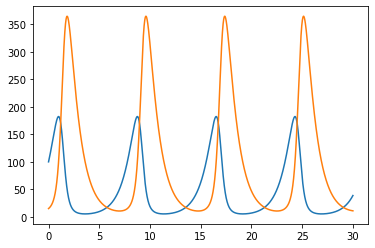

In [4]:
# Lotka Volterra data 
y_init = [100, 15]

# Horizon length for optimization problem (arbitrary time units) 
horizon_length = 20 

# Number of sampling time periods taken per MHE step
time_steps = 10 

# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 500 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = LV_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 5, 0, 5], False)
t, y_nf = LV_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0, 0, 0], False)

plt.plot(t,y)

**PySINDy setup**

In [4]:
# Creating costum basis function library 
from pysindy.feature_library import CustomLibrary

# Basis functions 
functions = [lambda x,y: 1, 
            lambda x,y: x,
            lambda x,y: y, 
            lambda x,y: x*y,
            lambda x,y: x**2,
            lambda x, y: y**2,
            lambda x, y: (x**2)*y,
            lambda x, y: x*(y**2),
            lambda x, y: x**3,
            lambda x, y: x**4,
            lambda x, y: y**3,
            lambda x, y: y**4,
#             lambda x, y: np.exp(x),
            lambda x, y: np.sin(x),
            lambda x, y: np.cos(x),
#             lambda x, y: np.exp(y),
            lambda x, y: np.sin(y),
            lambda x, y: np.cos(y)]

# Basis function names 
names = [lambda x,y: '1',
         lambda x,y: 'x',
         lambda x,y: 'y',
         lambda x,y: 'x*y',
         lambda x,y: 'x^2',
         lambda x,y: 'y^2',
         lambda x,y: '(x^2)*y',
         lambda x,y: 'x*(y^2)',
         lambda x,y: 'x^3',
         lambda x,y: 'x^4',
         lambda x,y: 'y^3',
         lambda x,y: 'y^4',
#          lambda x, y: 'exp(x)',
         lambda x,y: 'sin(x)',
         lambda x,y: 'cos(x)',
#          lambda x, y: 'exp(y)',
         lambda x,y: 'sin(y)',
         lambda x,y: 'cos(y)']

# Generating library 
lib = ps.CustomLibrary(library_functions = functions, function_names = names)

# Initializing arrays to collect results 
equations = {}
coefficients = {} 
MSE = [] 
complexity = [] 

# Defining PySINDy differentiation strategies 
diffs = [('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=2, drop_endpoints=False)),
        ('Smoothed Finite Difference', ps.SmoothedFiniteDifference(drop_endpoints=False)),
        ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2, drop_endpoints=False))]
derivative_dict = {} 
for name, method in diffs:
    derivative_dict[name] = method._differentiate(y,t)
    
# Defining the three different SINDy optimization methods considered: STLSQ, LASSO, and SR3
optimizer = ps.STLSQ(threshold=0.009)
lasso_optimizer = Lasso(alpha=1000, max_iter=5000, fit_intercept=False)
SRE_optimizer = ps.SR3
opts = ['SQTL', 'LASSO', 'SR3'] 

# Defining hyperparameter grids for optimizer settings
opts_params =  [1e-3, 1e-2, 1e-1, 1, 10]
nu_param = [0.1, 1, 10] 

# First loop iterates for all optimization methods 
for name_opt in opts: 
    # Second and third loops iterates for all optimization method parameters
    for param in opts_params:
        for param_1 in nu_param: 
            
            if name_opt == 'SQTL': 
                optimizer = ps.STLSQ(threshold=param)
            elif name_opt == 'LASSO': 
                optimizer = Lasso(alpha=param, max_iter=5000, fit_intercept=False)
            elif name_opt == 'SR3': 
                optimizer = ps.SR3(threshold=param, nu=param_1)
            
            # Last loop corresponds to the different differentiation instances
            for name_diff, method in diffs: 
                
                # Define the SINDy model 
                model = ps.SINDy(
                                differentiation_method=method,
                                feature_library=lib,
                                optimizer=optimizer,
                                feature_names=["x", "y"])
                # Fit the model and print results 
                try: 
                    model.fit(y,t, x_dot = derivative_dict[name_diff], quiet = True)
                    print(name_opt, ' ', param, ' ', name_diff)
                    model.print() 
                    MSE.append(model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error)) 
                    print('Model score: %f' % model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error))
                    print('Complexity x: ', len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])) 
                    print('Complexity y: ', len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                    print('\n')
                    complexity.append(len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])+len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                except: 
                    pass
            
            

SR3   0.001   Finite Difference
x' = 1.000 x + -0.010 x*y
y' = -1.000 y + 0.020 x*y
Model score: 0.000000
Complexity x:  2
Complexity y:  2


SR3   0.001   Smoothed Finite Difference
x' = 1.000 x + -0.010 x*y
y' = -1.000 y + 0.020 x*y
Model score: 0.000000
Complexity x:  2
Complexity y:  2


SR3   0.001   Spline
x' = 1.000 x + -0.010 x*y + 0.001 sin(y)
y' = -1.000 y + 0.020 x*y + -0.001 sin(x)
Model score: 0.000633
Complexity x:  2
Complexity y:  2


SR3   0.001   Finite Difference
x' = 1.000 x + -0.010 x*y
y' = -1.000 y + 0.020 x*y
Model score: 0.000000
Complexity x:  2
Complexity y:  2


SR3   0.001   Smoothed Finite Difference
x' = 1.000 x + -0.010 x*y
y' = -1.000 y + 0.020 x*y
Model score: 0.000000
Complexity x:  2
Complexity y:  2


SR3   0.001   Spline
x' = 1.000 x + -0.010 x*y + 0.001 sin(y)
y' = -1.000 y + 0.020 x*y + -0.001 sin(x)
Model score: 0.000633
Complexity x:  2
Complexity y:  2


SR3   0.001   Finite Difference
x' = 1.000 x + -0.010 x*y
y' = -1.000 y + 0.020 x*y
Model 

In [118]:
# Saving results for plotting latter
import pickle 
with open('sindy_LV_sigma_10.pickle', 'wb') as handle:
    pickle.dump({'complexity':complexity, 'MSE':MSE}, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sindy_LV_sigma_10.pickle', 'rb') as handle:
    sindy_LV_1 = pickle.load(handle)

# Van der pol 

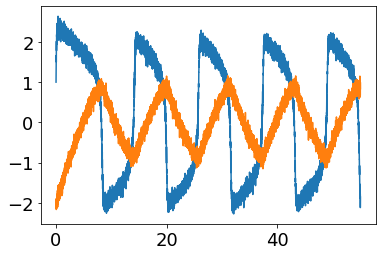

In [68]:
# Van der pol data 
y_init = [1, -2]

# Horizon length for optimization problem (arbitrary time units) 
horizon_length = 15 

# Number of sampling time periods taken per MHE step
time_steps = 40  

# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 200 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = VDP_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0.1, 0, 0.1], False)
t, y_nf = VDP_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0, 0, 0], False)

plt.plot(t,y)

In [69]:
poly_library = ps.PolynomialLibrary(degree = 4, include_interaction=True)

from pysindy.feature_library import CustomLibrary


functions = [lambda x,y: 1, 
            lambda x,y: x,
            lambda x,y: y, 
            lambda x,y: x*y,
            lambda x,y: x**2,
            lambda x, y: y**2,
            lambda x, y: (x**2)*y,
            lambda x, y: x*(y**2),
            lambda x, y: x**3,
            lambda x, y: x**4,
            lambda x, y: y**3,
            lambda x, y: y**4,
#             lambda x, y: np.exp(x),
            lambda x, y: np.sin(x),
            lambda x, y: np.cos(x),
#             lambda x, y: np.exp(y),
            lambda x, y: np.sin(y),
            lambda x, y: np.cos(y)]
names = [lambda x,y: '1',
         lambda x,y: 'x',
         lambda x,y: 'y',
         lambda x,y: 'x*y',
         lambda x,y: 'x^2',
         lambda x,y: 'y^2',
         lambda x,y: '(x^2)*y',
         lambda x,y: 'x*(y^2)',
         lambda x,y: 'x^3',
         lambda x,y: 'x^4',
         lambda x,y: 'y^3',
         lambda x,y: 'y^4',
#          lambda x, y: 'exp(x)',
         lambda x,y: 'sin(x)',
         lambda x,y: 'cos(x)',
#          lambda x, y: 'exp(y)',
         lambda x,y: 'sin(y)',
         lambda x,y: 'cos(y)']
lib = ps.CustomLibrary(library_functions = functions, function_names = names)

equations = {}
coefficients = {} 

diffs = [('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=2, drop_endpoints=False)),
        ('Smoothed Finite Difference', ps.SmoothedFiniteDifference(drop_endpoints=False)),
        ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2, drop_endpoints=False))]

derivative_dict = {} 
for name, method in diffs:
    derivative_dict[name] = method._differentiate(y,t)
    

optimizer = ps.STLSQ(threshold=0.009)
lasso_optimizer = Lasso(alpha=1000, max_iter=5000, fit_intercept=False)
SRE_optimizer = ps.SR3

opts = ['SQTL', 'LASSO', 'SR3'] 
opts_params =  [1e-3, 1e-2, 1e-1, 1, 10]
nu_param = [0.1, 1, 10] 

MSE = [] 
complexity = [] 
for name_opt in opts: 
    
    for param in opts_params:
        for param_1 in nu_param: 
        
            if name_opt == 'SQTL': 
                optimizer = ps.STLSQ(threshold=param)
            elif name_opt == 'LASSO': 
                optimizer = Lasso(alpha=param, max_iter=5000, fit_intercept=False)
            elif name_opt == 'SR3': 
                optimizer = ps.SR3(threshold=param, nu=param_1)

            for name_diff, method in diffs: 

                model = ps.SINDy(
                                differentiation_method=method,
                                feature_library=lib,
                                optimizer=optimizer,
                                feature_names=["x", "y"])
                try: 
                    model.fit(y,t, x_dot = derivative_dict[name_diff], quiet = True)
                    print(name_opt, ' ', param, ' ', name_diff)
                    model.print() 
                    MSE.append(model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error)) 
                    print('Model score: %f' % model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error))
                    print('Complexity x: ', len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])) 
                    print('Complexity y: ', len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                    print('\n')
                    complexity.append(len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])+len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                except: 
                    pass
            
            

/Users/ferlejarza/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:509: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


SR3   0.001   Finite Difference
x' = 705.333 1 + -32.133 x + -407.797 y + 0.244 x*y + -5.741 x^2 + -348.067 y^2 + 1.832 (x^2)*y + 1.498 x*(y^2) + 3.832 x^3 + 0.379 x^4 + 65.864 y^3 + 30.872 y^4 + 36.028 sin(x) + -12.667 cos(x) + 400.638 sin(y) + -693.497 cos(y)
y' = -261.769 1 + 10.950 x + 152.906 y + -0.023 x*y + -0.605 x^2 + 131.931 y^2 + -0.293 (x^2)*y + -0.192 x*(y^2) + -1.461 x^3 + 0.073 x^4 + -24.379 y^3 + -11.516 y^4 + -11.103 sin(x) + -0.768 cos(x) + -152.575 sin(y) + 262.720 cos(y)
Model score: 0.090744
Complexity x:  16
Complexity y:  16


SR3   0.001   Smoothed Finite Difference
x' = 400.135 1 + -40.172 x + -145.288 y + 0.088 x*y + 9.543 x^2 + -209.906 y^2 + 1.619 (x^2)*y + 1.264 x*(y^2) + 4.920 x^3 + -0.634 x^4 + 22.725 y^3 + 16.913 y^4 + 44.327 sin(x) + 19.901 cos(x) + 139.140 sin(y) + -419.839 cos(y)
y' = -26.008 1 + -5.713 x + 17.642 y + 0.020 x*y + 6.731 x^2 + 6.364 y^2 + 0.019 (x^2)*y + -0.068 x*(y^2) + 0.790 x^3 + -0.462 x^4 + -2.902 y^3 + -0.719 y^4 + 6.187 sin(x) + 

In [47]:
import pickle 
with open('sindy_VDP_sigma_01.pickle', 'wb') as handle:
    pickle.dump({'complexity':complexity, 'MSE':MSE}, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sindy_VDP_sigma_01.pickle', 'rb') as handle:
    sindy_VDP_0001 = pickle.load(handle)

# Brusselator

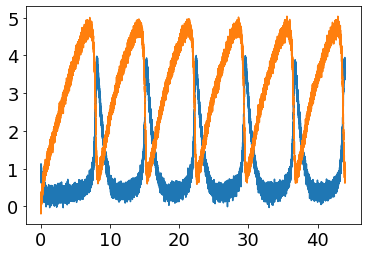

In [61]:
#Brusselator data 
y_init = [1, 0]

horizon_length = 4  # horizon length for optimization problem
time_steps = 40  # number of time steps taken in the MHE

# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 500 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = B_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0.1, 0, 0.1], False)
t, y_nf = B_data_generation.data_gen(xs, [y_init[0], y_init[1]], [0, 0, 0, 0], False)

plt.plot(t,y)

In [62]:
poly_library = ps.PolynomialLibrary(degree = 4, include_interaction=True)

from pysindy.feature_library import CustomLibrary


functions = [lambda x,y: 1, 
            lambda x,y: x,
            lambda x,y: y, 
            lambda x,y: x*y,
            lambda x,y: x**2,
            lambda x, y: y**2,
            lambda x, y: (x**2)*y,
            lambda x, y: x*(y**2),
            lambda x, y: x**3,
            lambda x, y: x**4,
            lambda x, y: y**3,
            lambda x, y: y**4,
#             lambda x, y: np.exp(x),
            lambda x, y: np.sin(x),
            lambda x, y: np.cos(x),
#             lambda x, y: np.exp(y),
            lambda x, y: np.sin(y),
            lambda x, y: np.cos(y)]
names = [lambda x,y: '1',
         lambda x,y: 'x',
         lambda x,y: 'y',
         lambda x,y: 'x*y',
         lambda x,y: 'x^2',
         lambda x,y: 'y^2',
         lambda x,y: '(x^2)*y',
         lambda x,y: 'x*(y^2)',
         lambda x,y: 'x^3',
         lambda x,y: 'x^4',
         lambda x,y: 'y^3',
         lambda x,y: 'y^4',
#          lambda x, y: 'exp(x)',
         lambda x,y: 'sin(x)',
         lambda x,y: 'cos(x)',
#          lambda x, y: 'exp(y)',
         lambda x,y: 'sin(y)',
         lambda x,y: 'cos(y)']
lib = ps.CustomLibrary(library_functions = functions, function_names = names)

equations = {}
coefficients = {} 

diffs = [('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=2, drop_endpoints=False)),
        ('Smoothed Finite Difference', ps.SmoothedFiniteDifference(drop_endpoints=False)),
        ('Spline', ps.SINDyDerivative(kind='spline', s=1e-2, drop_endpoints=False))]

derivative_dict = {} 
for name, method in diffs:
    derivative_dict[name] = method._differentiate(y,t)
    

optimizer = ps.STLSQ(threshold=0.009)
lasso_optimizer = Lasso(alpha=1000, max_iter=5000, fit_intercept=False)
SRE_optimizer = ps.SR3

opts = ['SQTL', 'LASSO','SR3'] 
opts_params =  [1e-3, 1e-2, 1e-1, 1, 10]
nu_param = [0.1, 1, 10] 

MSE = [] 
complexity = [] 
for name_opt in opts: 
    
    for param in opts_params:
        for param_1 in nu_param: 
        
            if name_opt == 'SQTL': 
                optimizer = ps.STLSQ(threshold=param)
            elif name_opt == 'LASSO': 
                optimizer = Lasso(alpha=param, max_iter=5000, fit_intercept=False)
            elif name_opt == 'SR3': 
                optimizer = ps.SR3(threshold=param, nu=param_1)

            for name_diff, method in diffs: 

                model = ps.SINDy(
                                differentiation_method=method,
                                feature_library=lib,
                                optimizer=optimizer,
                                feature_names=["x", "y"])
                try: 
                    model.fit(y,t, x_dot = derivative_dict[name_diff], quiet = True)
                    print(name_opt, ' ', param, ' ', name_diff)
                    model.print() 
                    MSE.append(model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error)) 
                    print('Model score: %f' % model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error))
                    print('Complexity x: ', len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])) 
                    print('Complexity y: ', len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                    print('\n')
                    complexity.append(len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])+len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                except: 
                    pass
            
            

SR3   0.001   Finite Difference
x' = 25.673 1 + 48.396 x + -31.267 y + 4.305 x*y + 4.082 x^2 + -7.590 y^2 + -0.109 (x^2)*y + -0.394 x*(y^2) + -13.200 x^3 + 2.047 x^4 + 6.828 y^3 + -0.812 y^4 + -60.422 sin(x) + -1.557 cos(x) + 23.294 sin(y) + -16.806 cos(y)
y' = 19.386 1 + 80.697 x + 22.222 y + -0.622 x*y + -60.167 x^2 + 27.389 y^2 + -0.947 (x^2)*y + 0.211 x*(y^2) + 5.046 x^3 + 0.771 x^4 + -12.515 y^3 + 1.233 y^4 + -54.716 sin(x) + -61.299 cos(x) + -23.764 sin(y) + 35.556 cos(y)
Model score: 0.146357
Complexity x:  16
Complexity y:  16


SR3   0.001   Smoothed Finite Difference
x' = 49.101 1 + -67.935 x + -6.467 y + -0.133 x*y + -30.062 x^2 + -13.863 y^2 + 0.950 (x^2)*y + 0.030 x*(y^2) + 22.826 x^3 + -2.832 x^4 + 5.872 y^3 + -0.573 y^4 + 71.341 sin(x) + -33.926 cos(x) + 9.385 sin(y) + -15.420 cos(y)
y' = 16.497 1 + -5.066 x + 13.057 y + -1.112 x*y + -30.171 x^2 + 6.518 y^2 + -0.761 (x^2)*y + 0.174 x*(y^2) + 11.740 x^3 + -1.072 x^4 + -3.796 y^3 + 0.398 y^4 + 17.557 sin(x) + -32.636 cos(x

In [8]:
import pickle 
with open('sindy_B_sigma_01.pickle', 'wb') as handle:
    pickle.dump({'complexity':complexity, 'MSE':MSE}, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sindy_B_sigma_01.pickle', 'rb') as handle:
    sindy_VDP_0001 = pickle.load(handle)

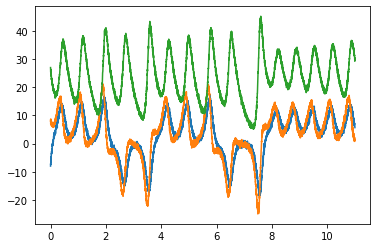

# Lorenz

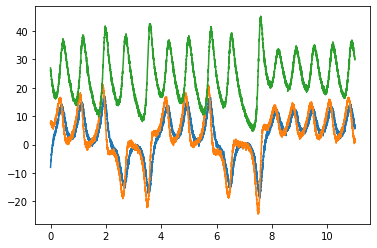

In [5]:
#Lorenz data 
y_init = [-8, 8, 27]

horizon_length = 6  # horizon length for optimization problem
time_steps = 5  # number of time steps taken in the MHE

# Data generation (time grid)
xs = np.linspace(0, horizon_length + time_steps, 500 * (horizon_length + time_steps) + 1)
# Data generation (simulating true dynamics on the time grid with addition of white noise )
t, y = L_data_generation.data_gen(xs, [y_init[0], y_init[1], y_init[2]], [0, 0.5, 0, 0.5,0,0.5], False)
t, y_nf = L_data_generation.data_gen(xs, [y_init[0], y_init[1], y_init[2]], [0, 0, 0, 0,0,0], False)
plt.plot(t,y)

In [12]:
poly_library = ps.PolynomialLibrary(degree = 4, include_interaction=True)

from pysindy.feature_library import CustomLibrary


functions = [lambda x,y,z: 1, 
            lambda x,y,z: x,
            lambda x,y,z: y, 
            lambda x,y,z: z, 
            lambda x,y,z: x*y,
            lambda x,y,z: x*z,
            lambda x,y,z: y*z,
            lambda x,y,z: x**2,
            lambda x,y,z: y**2,
            lambda x,y,z: z**2,
            lambda x,y,z: (x**2)*y,
            lambda x,y,z: x*(y**2),
            lambda x,y,z: x*(z**2),
            lambda x,y,z: z*(x**2),
            lambda x,y,z: y*(z**2),
            lambda x,y,z: z*(y**2),
            lambda x,y,z: x**3,
            lambda x,y,z: x**4,
            lambda x,y,z: y**3,
            lambda x,y,z: y**4,
            lambda x,y,z: z**3,
            lambda x,y,z: z**4,
#             lambda x, y: np.exp(x),
            lambda x,y,z: np.sin(x),
            lambda x,y,z: np.cos(x),
#             lambda x, y: np.exp(y),
            lambda x,y,z: np.sin(y),
            lambda x,y,z: np.cos(y), 
            lambda x,y,z: np.sin(z),
            lambda x,y,z: np.cos(z),]
names = [lambda x,y,z: '1',
         lambda x,y,z: 'x',
         lambda x,y,z: 'y',
         lambda x,y,z: 'z',
         lambda x,y,z: 'x*y',
         lambda x,y,z: 'x*z',
         lambda x,y,z: 'y*z',
         lambda x,y,z: 'x^2',
         lambda x,y,z: 'y^2',
         lambda x,y,z: 'z^2',
         lambda x,y,z: '(x^2)*y',
         lambda x,y,z: 'x*(y^2)',
         lambda x,y,z: '(x^2)*z',
         lambda x,y,z: 'z*(x^2)',
         lambda x,y,z: '(z^2)*y',
         lambda x,y,z: 'z*(y^2)',
         lambda x,y,z: 'x^3',
         lambda x,y,z: 'x^4',
         lambda x,y,z: 'y^3',
         lambda x,y,z: 'y^4',
         lambda x,y,z: 'z^3',
         lambda x,y,z: 'z^4',
#          lambda x, y: 'exp(x)',
         lambda x,y,z: 'sin(x)',
         lambda x,y,z: 'cos(x)',
#          lambda x, y: 'exp(y)',
         lambda x,y,z: 'sin(y)',
         lambda x,y,z: 'cos(y)',
         lambda x,y,z: 'sin(z)',
         lambda x,y,z: 'cos(z)']

lib = ps.CustomLibrary(library_functions = functions, function_names = names)

equations = {}
coefficients = {} 

diffs = [('Finite Difference', ps.SINDyDerivative(kind='finite_difference', k=2, drop_endpoints=False)),
        ('Smoothed Finite Difference', ps.SmoothedFiniteDifference(drop_endpoints=False)),
        ('Spline', ps.SINDyDerivative(kind='spline', s=1e-1, drop_endpoints=False))]

derivative_dict = {} 
for name, method in diffs:
    derivative_dict[name] = method._differentiate(y,t)
    

optimizer = ps.STLSQ(threshold=0.009)
lasso_optimizer = Lasso(alpha=1000, max_iter=5000, fit_intercept=False)
SRE_optimizer = ps.SR3

opts = ['SQTL', 'LASSO', 'SR3'] 
opts_params =  [1e-3, 1e-2, 1e-1, 1, 10]
nu_param = [0.1, 1, 10] 

MSE = [] 
complexity = [] 
for name_opt in opts: 
    
    for param in opts_params:
        for param_1 in nu_param: 
        
            if name_opt == 'SQTL': 
                optimizer = ps.STLSQ(threshold=param)
            elif name_opt == 'LASSO': 
                optimizer = Lasso(alpha=param, max_iter=5000, fit_intercept=False)
            elif name_opt == 'SR3': 
                optimizer = ps.SR3(threshold=param, nu=param_1)

            for name_diff, method in diffs: 
            
                model = ps.SINDy(
                                differentiation_method=method,
                                feature_library=lib,
                                optimizer=optimizer,
                                feature_names=["x", "y", "z"])


                model.fit(y,t = t[1]-t[0], x_dot = derivative_dict[name_diff], quiet = True)
                print(name_opt, ' ', param, ' ', name_diff)
                model.print() 
                MSE.append(model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error)) 
                print('Model score: %f' % model.score(x= y_nf, t = t[1]-t[0], metric = mean_squared_error))
                print('Complexity x: ', len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])) 
                print('Complexity y: ', len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)]))
                print('Complexity z: ', len([i for i in model.coefficients()[2] if np.abs(i) > 0.5*(0.01)]))
                print('\n')
                complexity.append(len([i for i in model.coefficients()[0] if np.abs(i) > 0.5*(0.01)])+
                                  len([i for i in model.coefficients()[1] if np.abs(i) > 0.5*(0.01)])+
                                  len([i for i in model.coefficients()[2] if np.abs(i) > 0.5*(0.01)]))
                


SR3   0.001   Finite Difference
x' = -42.608 1 + 3.968 x + 1.654 y + 8.209 z + 0.036 x*y + -0.631 x*z + 0.370 y*z + 0.974 x^2 + -0.367 y^2 + -0.464 z^2 + -0.013 (x^2)*y + 0.005 (x^2)*z + -0.035 z*(x^2) + -0.004 (z^2)*y + 0.010 z*(y^2) + 0.023 x^3 + 0.001 x^4 + 0.008 z^3 + -2.229 sin(x) + 0.465 cos(x) + -2.686 sin(y) + 2.757 cos(y) + 4.122 sin(z) + 6.007 cos(z)
y' = -19.877 1 + 16.648 x + 5.283 y + 4.820 z + 0.318 x*y + -0.473 x*z + -0.351 y*z + 1.404 x^2 + -0.509 y^2 + -0.324 z^2 + 0.010 (x^2)*y + -0.003 x*(y^2) + -0.004 (x^2)*z + -0.056 z*(x^2) + 0.006 (z^2)*y + 0.007 z*(y^2) + -0.027 x^3 + 0.002 x^4 + 0.003 y^3 + 0.006 z^3 + 1.188 sin(x) + 1.615 cos(x) + 0.328 sin(y) + 0.702 cos(y) + -4.445 sin(z) + -2.932 cos(z)
z' = 52.476 1 + 2.134 x + 2.353 y + -13.176 z + 0.381 x*y + -0.052 x*z + -0.341 y*z + -1.658 x^2 + 0.712 y^2 + 0.648 z^2 + -0.065 (x^2)*y + 0.060 x*(y^2) + 0.079 z*(x^2) + 0.010 (z^2)*y + -0.009 z*(y^2) + 0.006 x^3 + -0.003 x^4 + -0.015 y^3 + -0.013 z^3 + -2.285 sin(x) + -0.

In [13]:

with open('sindy_L_sigma_05_0929.pickle', 'wb') as handle:
    pickle.dump({'complexity':sindy_LV_1['complexity'], 'MSE':sindy_LV_1['MSE']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plotting results 

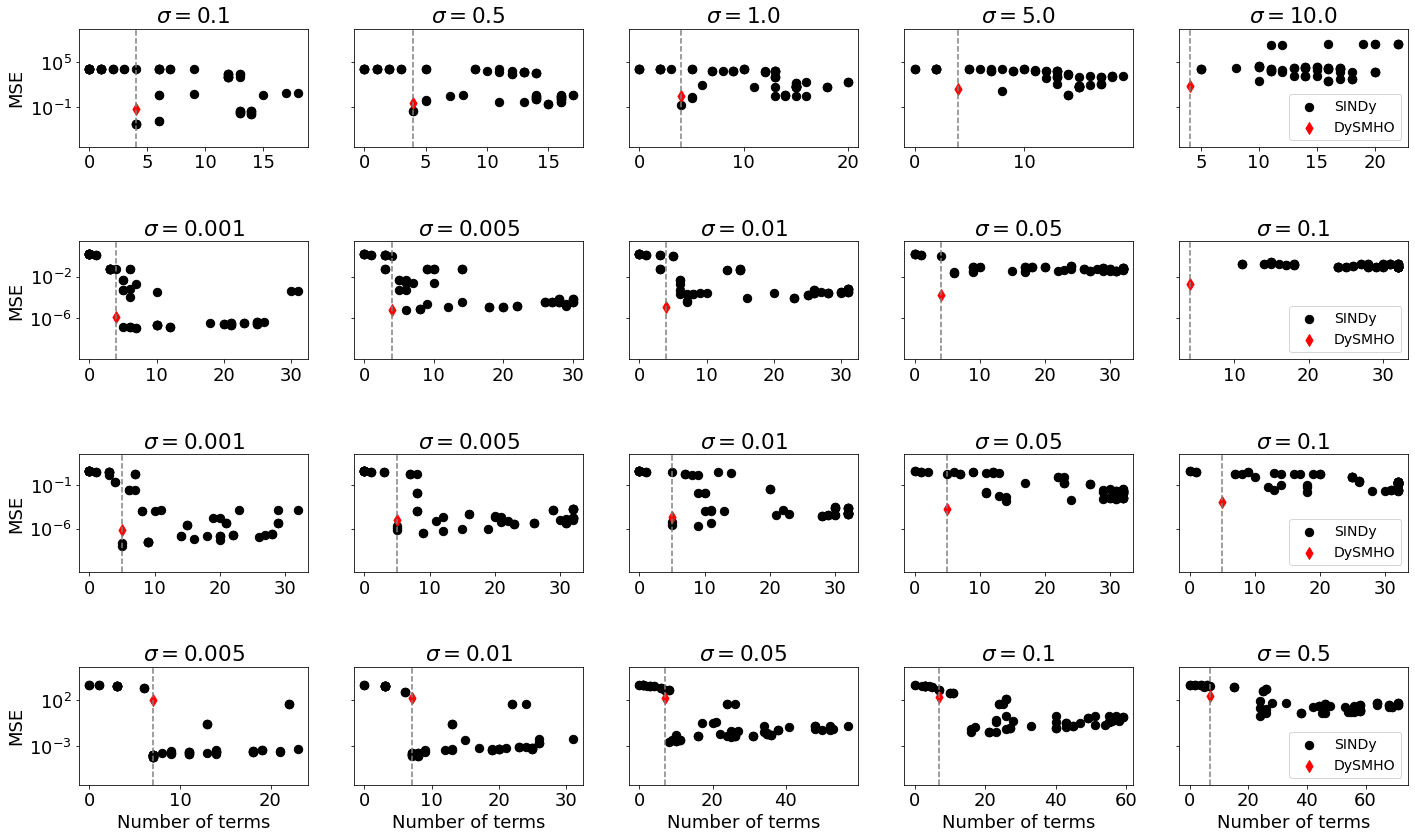

In [14]:
import matplotlib 
font = {'size'   : 18}
matplotlib.rc('font', **font)

with open('sindy_LV_sigma_01_0929.pickle', 'rb') as handle:
    sindy_LV_01 = pickle.load(handle)
    
with open('sindy_LV_sigma_05_0929.pickle', 'rb') as handle:
    sindy_LV_05 = pickle.load(handle)
    
with open('sindy_LV_sigma_1_0929.pickle', 'rb') as handle:
    sindy_LV_1 = pickle.load(handle)
    
with open('sindy_LV_sigma_5_0929.pickle', 'rb') as handle:
    sindy_LV_5 = pickle.load(handle)  
    
with open('sindy_LV_sigma_10_0929.pickle', 'rb') as handle:
    sindy_LV_10 = pickle.load(handle)
    
noise_vec = [0.1,	0.5,	1,	5,	10]
mean_mse = [0.0524813076432137,	0.35781970406356,	2.76208725370615,	26.9336940697845,	58.8229510496944]
std_mse = [0.0941274300246206,	0.553220314362161,	3.78837206091462,	28.792844642632,	73.8855930892199]

fig, axs = plt.subplots(4, 5, figsize = (20,12), sharey = 'row')



axs[0][0].scatter(sindy_LV_01['complexity'], sindy_LV_01['MSE'], color = 'k', s = 70) 
# axs[0][0].errorbar(4,mean_mse[0],yerr=2*std_mse[0], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[0][0].scatter(4,mean_mse[0], marker='d', color='red', s = 70)
axs[0][0].set_yscale('log')
axs[0][0].set_ylabel('MSE') 
axs[0][0].set_title(r'$\sigma = 0.1$') 
axs[0][0].set_ylim([0.001*min(sindy_LV_01['MSE']), 100*max(sindy_LV_10['MSE'])]) 

axs[0][1].scatter(sindy_LV_05['complexity'], sindy_LV_05['MSE'], color = 'k', s = 70) 
# axs[0][1].errorbar(4,mean_mse[1],yerr=2*std_mse[1], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[0][1].scatter(4,mean_mse[1], marker='d', color='red', s = 70)
axs[0][1].set_title(r'$\sigma = 0.5$') 

axs[0][2].scatter(sindy_LV_1['complexity'], sindy_LV_1['MSE'], color = 'k', s = 70) 
# axs[0][2].errorbar(4,mean_mse[2],yerr=2*std_mse[2], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[0][2].scatter(4,mean_mse[2], marker='d', color='red', s = 70)
axs[0][2].set_title(r'$\sigma = 1.0$') 

axs[0][3].scatter(sindy_LV_5['complexity'], sindy_LV_5['MSE'], color = 'k', s = 70) 
# axs[0][3].errorbar(4,mean_mse[3],yerr=2*std_mse[3], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[0][3].scatter(4,mean_mse[3], marker='d', color='red', s = 70)
axs[0][3].set_title(r'$\sigma = 5.0$')

axs[0][4].scatter(sindy_LV_10['complexity'], sindy_LV_10['MSE'], color = 'k', s = 70) 
# axs[0][4].errorbar(4,mean_mse[4],yerr=2*std_mse[4], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[0][4].scatter(4,mean_mse[4], marker='d', color='red', s = 70)
axs[0][4].set_title(r'$\sigma = 10.0$')
axs[0][4].legend(['SINDy', 'DySMHO'], fontsize = 14, loc = 'lower right') 


axs[0][0].axvline(x =4, color = 'grey', linestyle = '--')
axs[0][1].axvline(x =4, color = 'grey', linestyle = '--') 
axs[0][2].axvline(x =4, color = 'grey', linestyle = '--') 
axs[0][3].axvline(x =4, color = 'grey', linestyle = '--') 
axs[0][4].axvline(x =4, color = 'grey', linestyle = '--') 


# VAN DER POL 


with open('sindy_VDP_sigma_0001_0929.pickle', 'rb') as handle:
    sindy_LV_01 = pickle.load(handle)
    
with open('sindy_VDP_sigma_0005_0929.pickle', 'rb') as handle:
    sindy_LV_05 = pickle.load(handle)
    
with open('sindy_VDP_sigma_001_0929.pickle', 'rb') as handle:
    sindy_LV_1 = pickle.load(handle)
    
with open('sindy_VDP_sigma_005_0929.pickle', 'rb') as handle:
    sindy_LV_5 = pickle.load(handle)  
    
with open('sindy_VDP_sigma_01_0929.pickle', 'rb') as handle:
    sindy_LV_10 = pickle.load(handle)
    
noise_vec = [0.001,	0.005,	0.01,	0.05,	0.1]
mean_mse = [1.40833458848397E-06,	6.33978460831088E-06,	1.33241573311802E-05,	0.000191085805582674,	0.00192729927318037]
std_mse = [1.60709463272675E-06,	7.70473490431612E-06,	1.33766559200488E-05,	0.000280595366082622,	0.00194533708773222]

axs[1][0].scatter(sindy_LV_01['complexity'], sindy_LV_01['MSE'], color = 'k', s = 70) 
# axs[1][0].errorbar(4,mean_mse[0],yerr=2*std_mse[0], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[1][0].scatter(4,mean_mse[0], marker='d', color='red', s = 70)
axs[1][0].set_yscale('log')
axs[1][0].set_ylabel('MSE') 
axs[1][0].set_title(r'$\sigma = 0.001$') 
axs[1][0].set_ylim([0.001*min(sindy_LV_01['MSE']), 100*max(sindy_LV_10['MSE'])]) 


axs[1][1].scatter(sindy_LV_05['complexity'], sindy_LV_05['MSE'], color = 'k', s = 70) 
# axs[1][1].errorbar(4,mean_mse[1],yerr=2*std_mse[1], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[1][1].scatter(4,mean_mse[1], marker='d', color='red', s = 70)
axs[1][1].set_title(r'$\sigma = 0.005$') 

axs[1][2].scatter(sindy_LV_1['complexity'], sindy_LV_1['MSE'], color = 'k', s = 70) 
# axs[1][2].errorbar(4,mean_mse[2],yerr=2*std_mse[2], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[1][2].scatter(4,mean_mse[2], marker='d', color='red', s = 70)
axs[1][2].set_title(r'$\sigma = 0.01$') 

axs[1][3].scatter(sindy_LV_5['complexity'], sindy_LV_5['MSE'], color = 'k', s = 70) 
# axs[1][3].errorbar(4,mean_mse[3],yerr=2*std_mse[3], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[1][3].scatter(4,mean_mse[3], marker='d', color='red', s = 70)
axs[1][3].set_title(r'$\sigma = 0.05$')

axs[1][4].scatter(sindy_LV_10['complexity'], sindy_LV_10['MSE'], color = 'k', s = 70) 
# axs[1][4].errorbar(4,mean_mse[4],yerr=2*std_mse[4], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[1][4].scatter(4,mean_mse[4], marker='d', color='red', s = 70)
axs[1][4].set_title(r'$\sigma = 0.1$')
axs[1][4].legend(['SINDy', 'DySMHO'], fontsize = 14, loc = 'lower right') 


axs[1][0].axvline(x =4, color = 'grey', linestyle = '--') 
axs[1][1].axvline(x =4, color = 'grey', linestyle = '--') 
axs[1][2].axvline(x =4, color = 'grey', linestyle = '--') 
axs[1][3].axvline(x =4, color = 'grey', linestyle = '--') 
axs[1][4].axvline(x =4, color = 'grey', linestyle = '--') 


# BRUSSELATOR


noise_vec = [0.001,	0.005,	0.01,	0.05,	0.1]
mean_mse = [8.00557886113187E-07,	1.06802480995206E-05,	1.98199162983521E-05,	0.000191698079181117,	0.0011885176431112]
std_mse = [7.99247873656048E-07,	6.85196721200725E-06,	3.32540670616586E-05,	0.000259033971608392,	0.00111947184286488]


with open('sindy_B_sigma_0001_0929.pickle', 'rb') as handle:
    sindy_LV_01 = pickle.load(handle)
    
with open('sindy_B_sigma_0005_0929.pickle', 'rb') as handle:
    sindy_LV_05 = pickle.load(handle)
    
with open('sindy_B_sigma_001_0929.pickle', 'rb') as handle:
    sindy_LV_1 = pickle.load(handle)
    
with open('sindy_B_sigma_005_0929.pickle', 'rb') as handle:
    sindy_LV_5 = pickle.load(handle)  
    
with open('sindy_B_sigma_01_0929.pickle', 'rb') as handle:
    sindy_LV_10 = pickle.load(handle)
    

axs[2][0].scatter(sindy_LV_01['complexity'], sindy_LV_01['MSE'], color = 'k', s = 70) 
# axs[2][0].errorbar(5,mean_mse[0],yerr=2*std_mse[0], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[2][0].scatter(5,mean_mse[0], marker='d', color='red', s = 70)
axs[2][0].set_yscale('log')
axs[2][0].set_ylabel('MSE') 
axs[2][0].set_title(r'$\sigma = 0.001$') 
axs[2][0].set_ylim([0.001*min(sindy_LV_01['MSE']), 100*max(sindy_LV_10['MSE'])]) 


axs[2][1].scatter(sindy_LV_05['complexity'], sindy_LV_05['MSE'], color = 'k', s = 70) 
# axs[2][1].errorbar(5,mean_mse[1],yerr=2*std_mse[1], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[2][1].scatter(5,mean_mse[1], marker='d', color='red', s = 70)
axs[2][1].set_yscale('log')

axs[2][1].set_title(r'$\sigma = 0.005$') 

axs[2][2].scatter(sindy_LV_1['complexity'], sindy_LV_1['MSE'], color = 'k', s = 70) 
# axs[2][2].errorbar(5,mean_mse[2],yerr=2*std_mse[2], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[2][2].scatter(5,mean_mse[2], marker='d', color='red', s = 70)
axs[2][2].set_title(r'$\sigma = 0.01$') 

axs[2][3].scatter(sindy_LV_5['complexity'], sindy_LV_5['MSE'], color = 'k', s = 70) 
axs[2][3].scatter(5,mean_mse[3], marker='d', color='red', s = 70)
# axs[2][3].errorbar(5,mean_mse[3],yerr=2*std_mse[3], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[2][3].set_title(r'$\sigma = 0.05$')

axs[2][4].scatter(sindy_LV_10['complexity'], sindy_LV_10['MSE'], color = 'k', s = 70)
axs[2][4].scatter(5,mean_mse[4], marker='d', color='red', s = 70)
# axs[2][4].errorbar(5,mean_mse[4],yerr=2*std_mse[4], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[2][4].set_title(r'$\sigma = 0.1$')
axs[2][4].legend(['SINDy', 'DySMHO'], fontsize = 14, loc = 'lower right') 


axs[2][0].axvline(x =5, color = 'grey', linestyle = '--') 
axs[2][1].axvline(x =5, color = 'grey', linestyle = '--') 
axs[2][2].axvline(x =5, color = 'grey', linestyle = '--') 
axs[2][3].axvline(x =5, color = 'grey', linestyle = '--') 
axs[2][4].axvline(x =5, color = 'grey', linestyle = '--') 


# LORENZ 

noise_vec = [0.005,	0.01,	0.05,	0.1,	0.5]
mean_mse = [108.185420034004,	150.61394218087,	172.180265934423,	212.264618500333,	296.347173560822]
std_mse = [86.1653631068622,	86.6422806564137,	67.6549997784222,	36.0738034472883,	55.0603743532534]


with open('sindy_L_sigma_0005_0929.pickle', 'rb') as handle:
    sindy_LV_01 = pickle.load(handle)
    
with open('sindy_L_sigma_001_0929.pickle', 'rb') as handle:
    sindy_LV_05 = pickle.load(handle)
    
with open('sindy_L_sigma_005_0929.pickle', 'rb') as handle:
    sindy_LV_1 = pickle.load(handle)
    
with open('sindy_L_sigma_01_0929.pickle', 'rb') as handle:
    sindy_LV_5 = pickle.load(handle)  
    
with open('sindy_L_sigma_05_0929.pickle', 'rb') as handle:
    sindy_LV_10 = pickle.load(handle)
    

axs[3][0].scatter(sindy_LV_01['complexity'], sindy_LV_01['MSE'], color = 'k', s = 70) 
# axs[3][0].errorbar(7,mean_mse[0],yerr=2*std_mse[0], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[3][0].scatter(7,mean_mse[0], marker='d', color='red', s = 70)
axs[3][0].set_yscale('log')
axs[3][0].set_xlabel('Number of terms') 
axs[3][0].set_ylabel('MSE') 
axs[3][0].set_title(r'$\sigma = 0.005$') 
axs[3][0].set_ylim([0.001*min(sindy_LV_01['MSE']), 100*max(sindy_LV_10['MSE'])]) 


axs[3][1].scatter(sindy_LV_05['complexity'], sindy_LV_05['MSE'], color = 'k', s = 70) 
# axs[3][1].errorbar(7,mean_mse[1],yerr=2*std_mse[1], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[3][1].scatter(7,mean_mse[1], marker='d', color='red', s = 70)
axs[3][1].set_yscale('log')
axs[3][1].set_xlabel('Number of terms') 
axs[3][1].set_title(r'$\sigma = 0.01$') 

axs[3][2].scatter(sindy_LV_1['complexity'], sindy_LV_1['MSE'], color = 'k', s = 70) 
# axs[3][2].errorbar(7,mean_mse[2],yerr=2*std_mse[2], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[3][2].scatter(7,mean_mse[2], marker='d', color='red', s = 70)
axs[3][2].set_yscale('log')
axs[3][2].set_xlabel('Number of terms') 
axs[3][2].set_title(r'$\sigma = 0.05$') 

axs[3][3].scatter(sindy_LV_5['complexity'], sindy_LV_5['MSE'], color = 'k', s = 70) 
axs[3][3].scatter(7,mean_mse[3], marker='d', color='red', s = 70)
# axs[3][3].errorbar(7,mean_mse[3],yerr=2*std_mse[3], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[3][3].set_yscale('log')
axs[3][3].set_xlabel('Number of terms') 
axs[3][3].set_title(r'$\sigma = 0.1$')

axs[3][4].scatter(sindy_LV_10['complexity'], sindy_LV_10['MSE'], color = 'k', s = 70) 
axs[3][4].scatter(7,mean_mse[4], marker='d', color='red', s = 70)
# axs[3][4].errorbar(7,mean_mse[4],yerr=2*std_mse[4], fmt='d', ecolor = 'red', color='red', markersize = 6)
axs[3][4].set_yscale('log')
axs[3][4].set_xlabel('Number of terms') 
axs[3][4].set_title(r'$\sigma = 0.5$')
axs[3][4].legend(['SINDy', 'DySMHO'], fontsize = 14, loc = 'lower right') 

axs[3][0].axvline(x =7, color = 'grey', linestyle = '--') 
axs[3][1].axvline(x =7, color = 'grey', linestyle = '--') 
axs[3][2].axvline(x =7, color = 'grey', linestyle = '--') 
axs[3][3].axvline(x =7, color = 'grey', linestyle = '--') 
axs[3][4].axvline(x =7, color = 'grey', linestyle = '--') 



plt.tight_layout()
plt.subplots_adjust(wspace = 0.2, hspace = 0.8) 
plt.savefig('./sindy_dysmho_experiments') 
